# Лабораторная работа №1: Первичное исследование данных

# 1. Постановка задачи
Данные представляют собой записи о продажах видеоигр по всему миру (~16,000 записей). Датасет содержит информацию о названиях игр, платформах, жанрах, издателях и объемах продаж по регионам (Северная Америка, Европа, Япония, остальные регионы).

## Условный заказчик
Заказчиком анализа может выступать компания-разработчик игр, издатель или инвестор игровой индустрии.

## Возможные задачи ИАД
- **кластеризация игр** по продажам и характеристикам;
- **сегментация рынка** по регионам и предпочтениям;
- **описательная аналитика** трендов платформ/жанров;
- **прогнозирование успеха** новых релизов;
- **рекомендательные системы** для издателей;

## 2. Паспорт датасета

### Загрузка данных

In [1]:
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = pd.read_csv('../data/vgsales.csv')
print(f'Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов')

print('Список всех признаков, их типов и описаний:')
columns_descriptions = {
    'Rank': 'Позиция игры в рейтинге по глобальным продажам',
    'Name': 'Название видеоигры',
    'Platform': 'Игровая платформа',
    'Year': 'Год выпуска игры',
    'Genre': 'Жанр игры',
    'Publisher': 'Издатель игры',
    'NA_Sales': 'Продажи в Северной Америке (млн копий)',
    'EU_Sales': 'Продажи в Европе (млн копий)',
    'JP_Sales': 'Продажи в Японии (млн копий)',
    'Other_Sales': 'Продажи в остальных регионах (млн копий)',
    'Global_Sales': 'Глобальные продажи (млн копий)'
}

for col in df.columns:
    col_type = str(df[col].dtype)
    description = columns_descriptions.get(col)
    print(f"{col:<15} {col_type:<12} - {description}")

df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df['Platform'] = df['Platform'].astype('category')
df['Genre'] = df['Genre'].astype('category')
df['Publisher'] = df['Publisher'].astype('category')

print(f'\nИтоговые преобразованные типы данных:\n{df.dtypes}')


Размер датасета: 16602 строк, 11 столбцов
Список всех признаков, их типов и описаний:
Rank            int64        - Позиция игры в рейтинге по глобальным продажам
Name            str          - Название видеоигры
Platform        str          - Игровая платформа
Year            float64      - Год выпуска игры
Genre           str          - Жанр игры
Publisher       str          - Издатель игры
NA_Sales        float64      - Продажи в Северной Америке (млн копий)
EU_Sales        float64      - Продажи в Европе (млн копий)
JP_Sales        float64      - Продажи в Японии (млн копий)
Other_Sales     float64      - Продажи в остальных регионах (млн копий)
Global_Sales    float64      - Глобальные продажи (млн копий)

Итоговые преобразованные типы данных:
Rank                     int64
Name                       str
Platform              category
Year            datetime64[us]
Genre                 category
Publisher             category
NA_Sales               float64
EU_Sales               

## 3. Аудит качества данных
### 3.1. Пропуски

In [3]:
missings = pd.DataFrame({
    'Количество пропусков': df.isnull().sum(),
    'Доля пропусков, %': round((df.isnull().sum() / df.shape[0] * 100), 2)
})
print(missings)
print(f"\nПризнаки с наибольшим количеством пропусков:\nYear (Год выхода) - 1,63%\nPublisher (Издатель) - 0.35%")
print("Наиболее проблемный признак - Year, наличие пропусков может затруднить временной анализ и тренды по годам.\nПризнак Publisher менее критичен, но важен для анализа качества издателей")

              Количество пропусков  Доля пропусков, %
Rank                             0               0.00
Name                             0               0.00
Platform                         0               0.00
Year                           271               1.63
Genre                            0               0.00
Publisher                       58               0.35
NA_Sales                         0               0.00
EU_Sales                         0               0.00
JP_Sales                         0               0.00
Other_Sales                      0               0.00
Global_Sales                     0               0.00

Признаки с наибольшим количеством пропусков:
Year (Год выхода) - 1,63%
Publisher (Издатель) - 0.35%
Наиболее проблемный признак - Year, наличие пропусков может затруднить временной анализ и тренды по годам.
Признак Publisher менее критичен, но важен для анализа качества издателей


### 3.2. Дубликаты


In [4]:
total_duplicates = df.duplicated().sum()
print(f"Количество полностью дублирующихся строк: {total_duplicates}")

Количество полностью дублирующихся строк: 4


### 3.3. Типические проблемы значений

In [5]:
numeric_cols = df.select_dtypes(include=['number']).columns
stats = df[numeric_cols].describe()
custom_stats = stats.loc[['count', 'mean', 'std', 'min', 'max']].round(2)
print("Числовые признаки:")
print(custom_stats)

print("\nПроверка отрицательных значений:")
negative_values = (df[numeric_cols] < 0).sum()
negative_problematic = negative_values[negative_values > 0]

if negative_problematic.empty:
    print("Отрицательные значения отсутствуют.")
else:
    print("Столбцы с отрицательными значениями:")
    for col, count in negative_problematic.items():
        print(f"  {col}: {count} шт.")

print("\nКатегориальные признаки:")

category_cols = df.select_dtypes(include=['object', 'string', 'category']).columns
for col in category_cols:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} уникальных значений")

    has_double_spaces = df[col].str.contains(r'  ', na=False).sum()
    if has_double_spaces > 0:
        print(f"  Двойные пробелы: {has_double_spaces} значений")


Числовые признаки:
           Rank  NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
count  16602.00  16602.00  16602.00  16602.00     16602.00      16602.00
mean    8298.65      0.27      0.15      0.08         0.05          0.54
std     4792.93      0.82      0.51      0.31         0.19          1.57
min        1.00      0.00      0.00      0.00        -0.05          0.01
max    16600.00     41.49     29.02     10.22        10.57         82.74

Проверка отрицательных значений:
Столбцы с отрицательными значениями:
  Other_Sales: 6 шт.

Категориальные признаки:
Name: 11494 уникальных значений
  Двойные пробелы: 13 значений
Platform: 31 уникальных значений
Genre: 12 уникальных значений
Publisher: 583 уникальных значений
  Двойные пробелы: 6 значений


### 3.4. Выбросы


Анализ выбросов в Global_Sales:
Q1 (25%): 0.06
Q3 (75%): 0.47
IQR: 0.41
Нижняя граница: -0.55
Верхняя граница: 1.08
Количество выбросов: 1897 (11.4%)


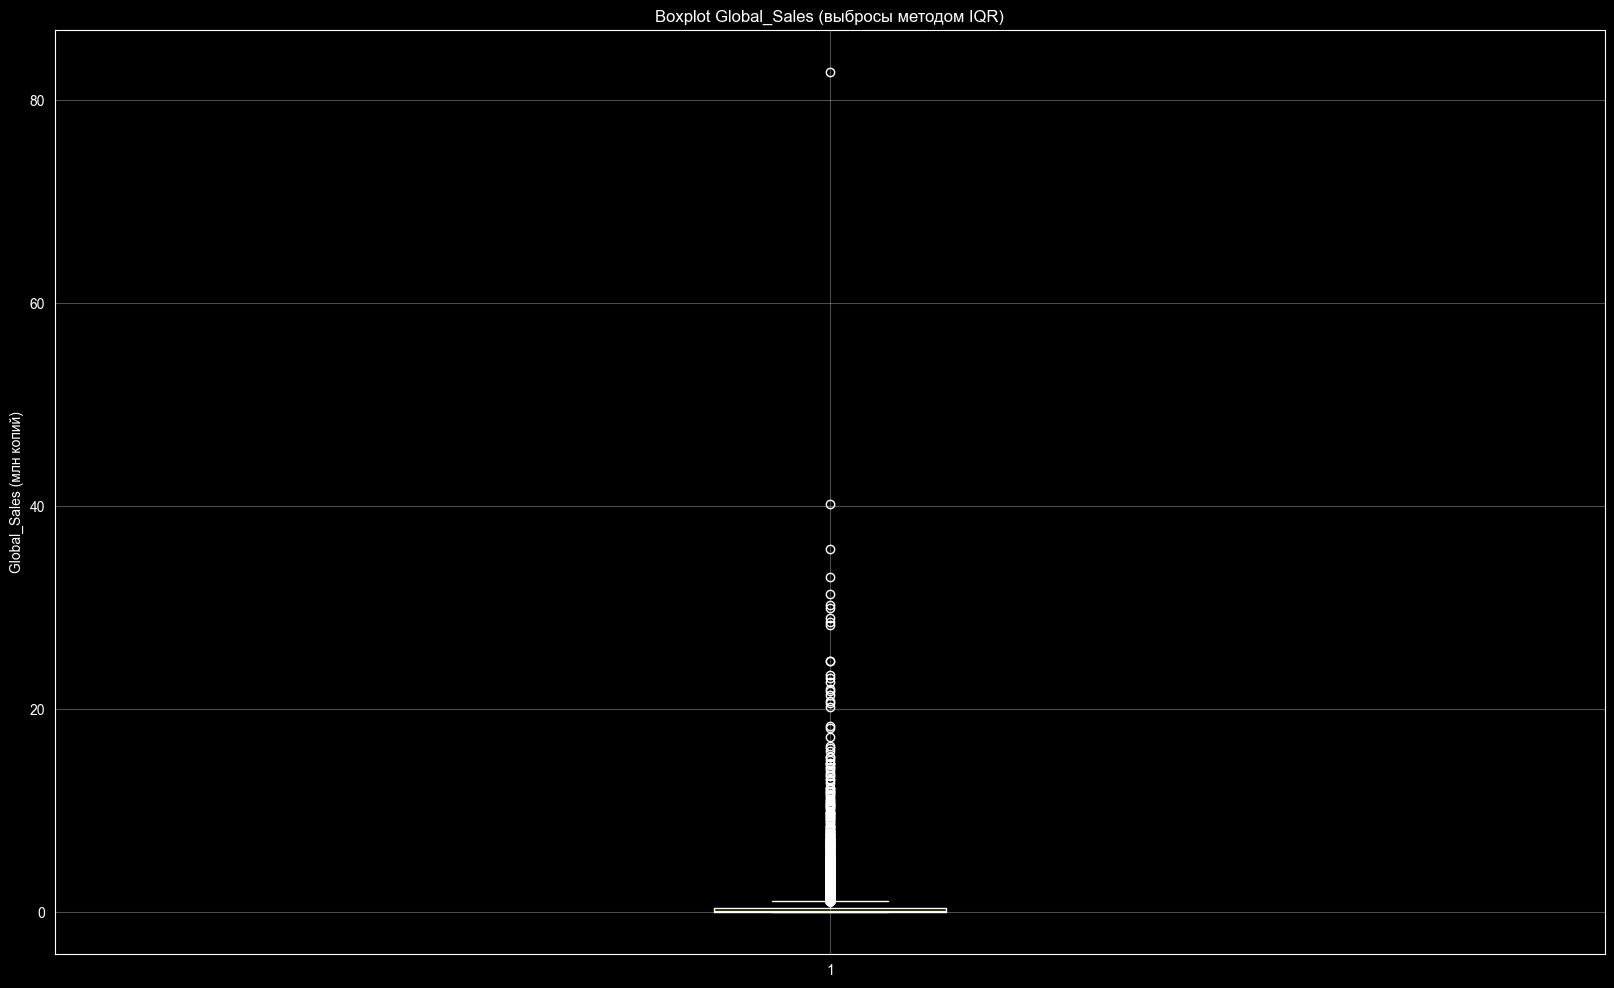


Наблюдения-выбросы (первые 5):
                       Name Platform  Global_Sales
0                Wii Sports      Wii         82.74
1         Super Mario Bros.      NES         40.24
2            Mario Kart Wii      Wii         35.82
3         Wii Sports Resort      Wii         33.00
4  Pokemon Red/Pokemon Blue       GB         31.37


In [6]:
print("\nАнализ выбросов в Global_Sales:")

Q1 = df['Global_Sales'].quantile(0.25)
Q3 = df['Global_Sales'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Global_Sales'] < lower_bound) | (df['Global_Sales'] > upper_bound)]
print(f"Q1 (25%): {Q1:.2f}")
print(f"Q3 (75%): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Нижняя граница: {lower_bound:.2f}")
print(f"Верхняя граница: {upper_bound:.2f}")
print(f"Количество выбросов: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))
plt.boxplot(df['Global_Sales'].dropna(), vert=True)
plt.title('Boxplot Global_Sales (выбросы методом IQR)')
plt.ylabel('Global_Sales (млн копий)')
plt.grid(True, alpha=0.3)
plt.show()

print("\nНаблюдения-выбросы (первые 5):")
print(outliers[['Name', 'Platform', 'Global_Sales']].head())


## 4. Мини-EDA (разведочный анализ)

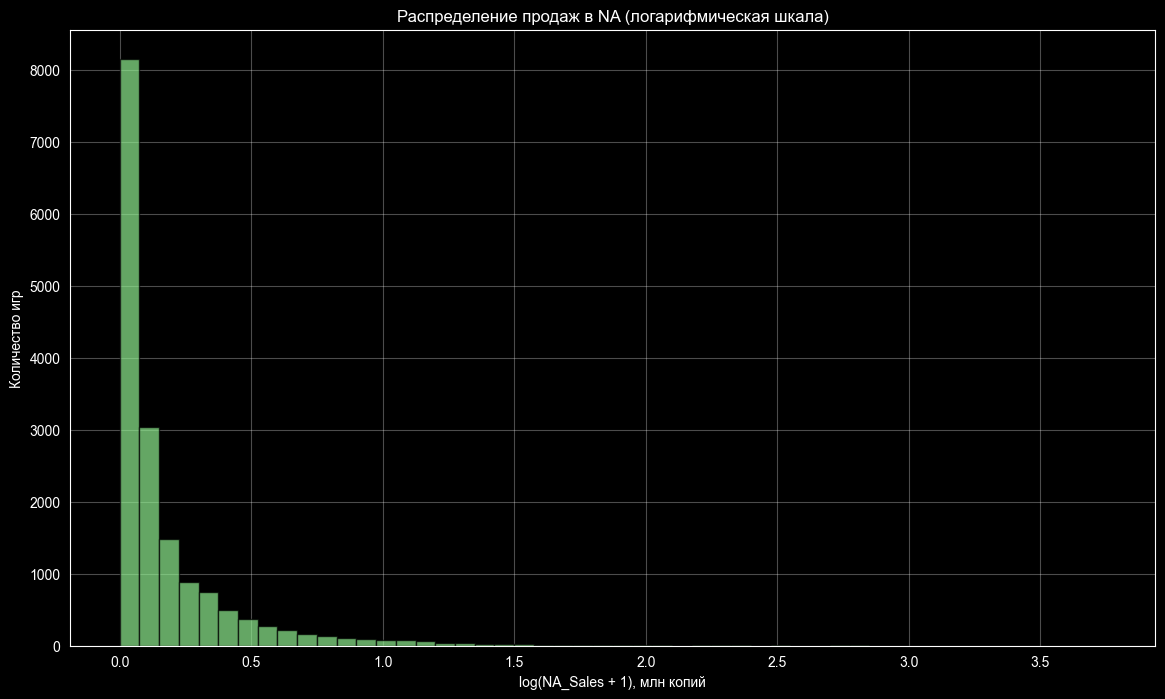

КОММЕНТАРИЙ 1
Видно: даже в логарифмической шкале распределение скошено.
Гипотеза: подавляющее большинство игр — низкие продажи (<0.5 млн).
Вопрос: сколько игр можно считать 'успешными'?




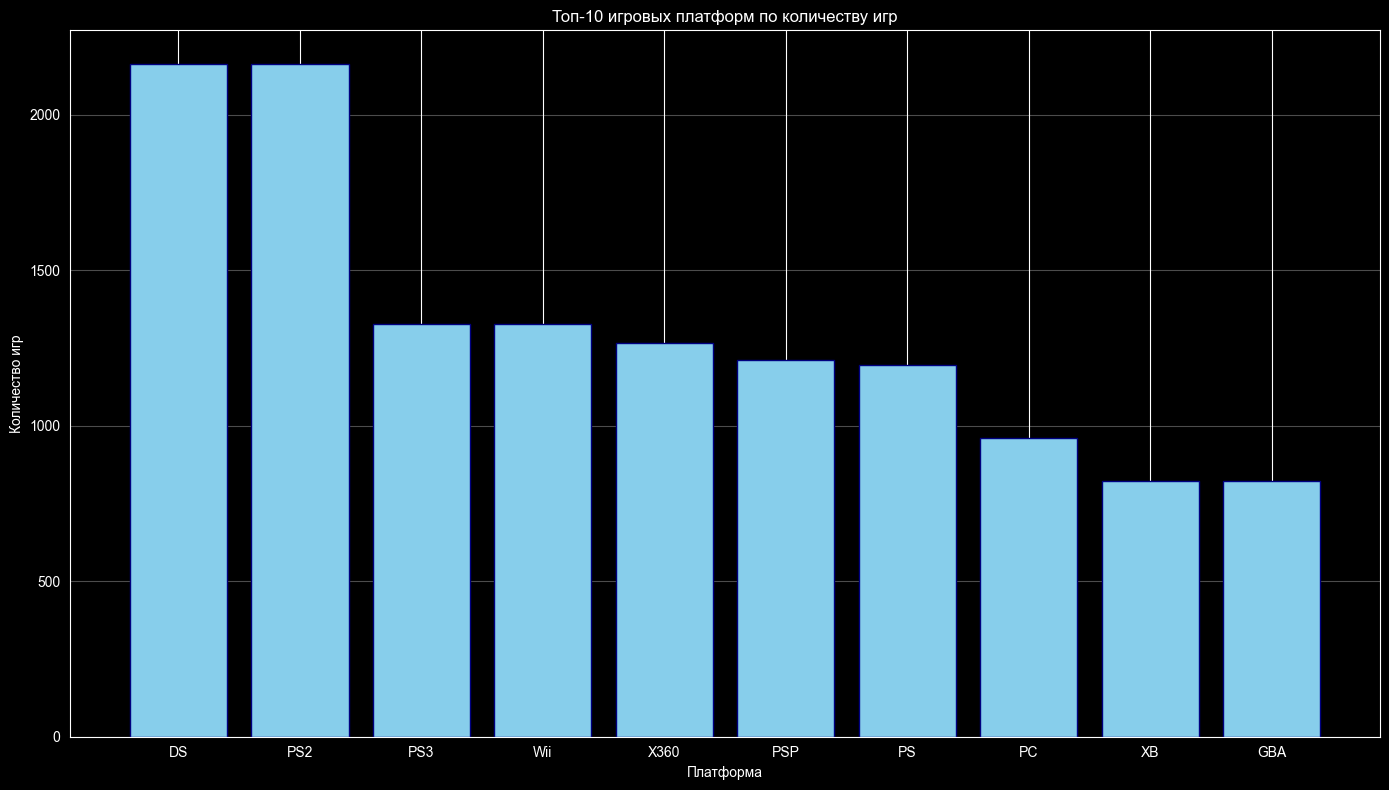

КОММЕНТАРИЙ 2
Видно: DS, PS2 и PS3 лидируют по количеству выпущенных игр.
Гипотеза: пик активности приходится на конец 90-х - середину 2000-х.
Вопрос: почему именно эти платформы доминируют на рынке?




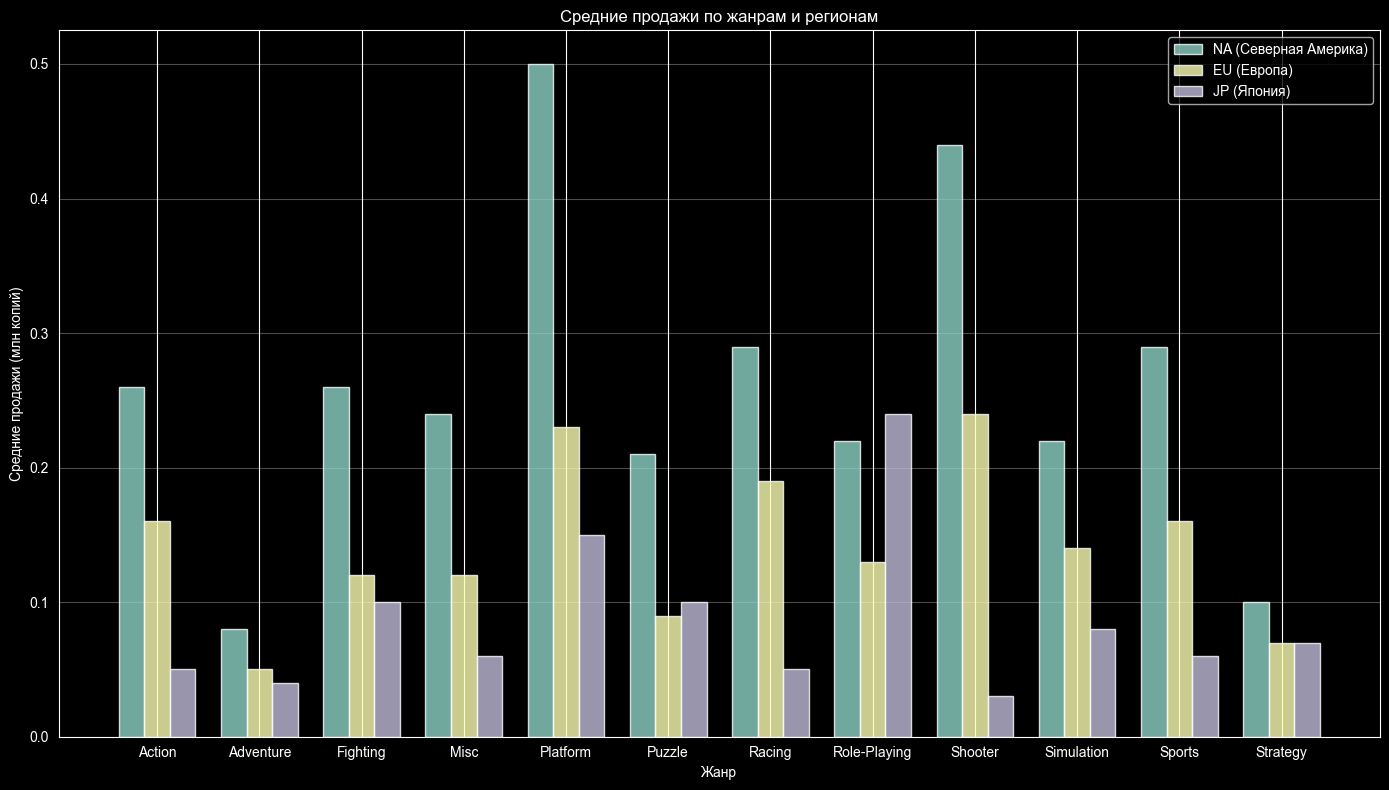

КОММЕНТАРИЙ 3
Видно: Северная америка и Европа предпочитает платформеры и шутеры, а в Японии доминируют ролевые игры.
Гипотеза: культурные предпочтения сильно влияют на популярность жанров.
Вопрос: связаны ли региональные предпочтения с популярностью платформ?


In [8]:
plt.figure(figsize=(14, 8))
plt.hist(np.log1p(df['NA_Sales'].clip(lower=0)), bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
plt.title('Распределение продаж в NA (логарифмическая шкала)')
plt.xlabel('log(NA_Sales + 1), млн копий')
plt.ylabel('Количество игр')
plt.grid(True, alpha=0.3)
plt.show()
print("КОММЕНТАРИЙ 1")
print("Видно: даже в логарифмической шкале распределение скошено.")
print("Гипотеза: подавляющее большинство игр — низкие продажи (<0.5 млн).")
print("Вопрос: сколько игр можно считать 'успешными'?\n\n")

plt.figure(figsize=(14, 8))
platform_counts = df['Platform'].value_counts().head(10)
plt.bar(platform_counts.index, platform_counts.values, color='skyblue', edgecolor='navy')
plt.title('Топ-10 игровых платформ по количеству игр')
plt.xlabel('Платформа')
plt.ylabel('Количество игр')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
print("КОММЕНТАРИЙ 2")
print("Видно: DS, PS2 и PS3 лидируют по количеству выпущенных игр.")
print("Гипотеза: пик активности приходится на конец 90-х - середину 2000-х.")
print("Вопрос: почему именно эти платформы доминируют на рынке?\n\n")

plt.figure(figsize=(14, 8))
genre_sales = df.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales']].mean().round(2)
x = np.arange(len(genre_sales.index))
width = 0.25
plt.bar(x - width, genre_sales['NA_Sales'], width, label='NA (Северная Америка)', alpha=0.8)
plt.bar(x, genre_sales['EU_Sales'], width, label='EU (Европа)', alpha=0.8)
plt.bar(x + width, genre_sales['JP_Sales'], width, label='JP (Япония)', alpha=0.8)
plt.title('Средние продажи по жанрам и регионам')
plt.xlabel('Жанр')
plt.ylabel('Средние продажи (млн копий)')
plt.xticks(x, genre_sales.index)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
print("КОММЕНТАРИЙ 3")
print("Видно: Северная америка и Европа предпочитает платформеры и шутеры, а в Японии доминируют ролевые игры.")
print("Гипотеза: культурные предпочтения сильно влияют на популярность жанров.")
print("Вопрос: связаны ли региональные предпочтения с популярностью платформ?")

